In [54]:
# Imports
import os
import earthaccess
import pandas as pd
import laspy
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from fastkml import kml
import xml.etree
import requests
from urllib.parse import urlparse
import json
import pdal
from geopy.distance import distance

In [2]:
# attempt to authenticate earthaccess
try:
    auth = earthaccess.login()
    if auth.authenticated:
        print("Successfully authenticated with earthaccess.")
    else:
        print("Authentication failed. Check credentials.")
except Exception as e:
    print(f"An error occurred during earthaccess login: {e}")

Successfully authenticated with earthaccess.


In [3]:
data_path = os.path.join(
    os.getcwd(),
    'lidar_filtered')
file_name = 'cms_brazil_lidar_tile_inventory.csv'

file_path = os.path.join(
    data_path,
    file_name)

In [75]:
index = 16

df = pd.read_csv(file_path)
print(f"Number of tiles: {len(df)}")

tile_name = df.iloc[index]["filename"]
print(f"\nTilename: {tile_name}")


Number of tiles: 3152

Tilename: ANA_A01_2018_LAS_11.laz


In [76]:
row = df[df["filename"] == tile_name]

In [77]:
centre_lat = (sum(row["min_lat"], row["max_lat"])/2).iloc[0]
centre_lon = (sum(row["min_lon"], row["max_lon"])/2).iloc[0]

print("latitude/longitude coords")
print(f"{float(centre_lat)} {centre_lon}")

latitude/longitude coords
-3.3778313375 -54.9981431


In [ ]:
def get_coords_and_dimensions(first_index, last_index):
    coords = []
    for index in range(first_index, last_index):
        row = df.iloc[index]
        tile_name = row["filename"]
        
        min_lat, max_lat = row["min_lat"], row["max_lat"]
        min_lon, max_lon = row["min_lon"], row["max_lon"]

        centre_lat = (min_lat + max_lat) / 2
        centre_lon = (min_lon + max_lon) / 2

        # Width: E-W distance (constant latitude)
        width_m = distance((centre_lat, min_lon), (centre_lat, max_lon)).m
        # Height: N-S distance (constant longitude)
        height_m = distance((min_lat, centre_lon), (max_lat, centre_lon)).m

        coords.append((index, tile_name, centre_lat, centre_lon, width_m, height_m))
    
    return coords
    #     tile_name = df.iloc[index]["filename"]
    #     row = df[df["filename"] == tile_name]
    #     centre_lat = (sum(row["min_lat"], row["max_lat"])/2).iloc[0]
    #     centre_lon = (sum(row["min_lon"], row["max_lon"])/2).iloc[0]
    #     coords.append((index, tile_name, centre_lat, centre_lon))
    # return coords
coords = get_coords_and_dimensions(0, len(df))
for i, coord in enumerate(coords):
    _, _, lat, lon, width, height = coord
    print(f"index: {i}; {lat:.5f} {lon:.5f}; {width:.0f} x {height:.0f}")

index: 0; -3.36802 -54.99742; 1002 x 1002
index: 1; -3.35108 -55.00602; 905 x 752
index: 2; -3.38177 -54.99739; 1000 x 44
index: 3; -3.36804 -55.00600; 910 x 1002
index: 4; -3.37704 -54.98974; 705 x 1001
index: 5; -3.38178 -55.00598; 910 x 42
index: 6; -3.35896 -54.98976; 709 x 1001
index: 7; -3.37708 -55.00599; 912 x 1002
index: 8; -3.35899 -55.00601; 908 x 1002
index: 9; -3.35106 -54.98977; 710 x 748
index: 10; -3.38176 -54.98974; 701 x 45
index: 11; -3.37706 -54.99740; 1002 x 1002
index: 12; -3.35107 -54.99745; 1001 x 751
index: 13; -3.37784 -55.00637; 830 x 912
index: 14; -3.36920 -55.00638; 828 x 1001
index: 15; -3.36013 -54.99013; 791 x 1001
index: 16; -3.37783 -54.99814; 1002 x 915
index: 17; -3.35165 -54.99014; 792 x 877
index: 18; -3.35165 -54.99820; 1002 x 880
index: 19; -3.36016 -55.00639; 826 x 1001
index: 20; -3.35166 -55.00639; 824 x 881
index: 21; -3.36014 -54.99818; 1002 x 1002
index: 22; -3.36917 -54.99012; 789 x 1001
index: 23; -3.37782 -54.99011; 786 x 916
index: 24;

In [78]:
import folium
from IPython.display import display
from geopy.distance import distance

# Centre point
index = 16
lat, lon = coords[index][2], coords[index][3]

# Compute approx bounds 500 m in each direction
d = 0.5  # km
south = distance(kilometers=d).destination((lat, lon), bearing=180).latitude
north = distance(kilometers=d).destination((lat, lon), bearing=0).latitude
west = distance(kilometers=d).destination((lat, lon), bearing=270).longitude
east = distance(kilometers=d).destination((lat, lon), bearing=90).longitude

# Create map centred at lat/lon
m = folium.Map(location=[lat, lon], zoom_start=17, tiles="Esri.WorldImagery")

# Fit to 1 km bounding box
m.fit_bounds([[south, west], [north, east]])

# Optional: add rectangle to highlight 1 km tile
folium.Rectangle(
    bounds=[[south, west], [north, east]],
    color="red", fill=False
).add_to(m)

# Display
display(m)


In [79]:
base_url = "https://daac.ornl.gov/daacdata/cms/LiDAR_Forest_Inventory_Brazil/data/"
full_url = os.path.join(base_url, tile_name)

download_folder = os.path.join(
    os.getcwd(),
    "data",
    "raw"
)

os.makedirs(download_folder, exist_ok=True)
download_path = os.path.join(
    download_folder,
    tile_name
)

with requests.Session() as session:
    session.auth = None
    session.headers.update({"User-Agent": "earthdata-download-script"})

    response = session.get(full_url, allow_redirects=True)
    if response.status_code == 200:
        with open(download_path, "wb") as f:
            f.write(response.content)
        print(f"Downloaded to: {download_path}")
    else:
        print(f"Failed to download {tile_name}: {response.status_code}")

Downloaded to: /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/raw/ANA_A01_2018_LAS_11.laz


In [84]:
path_to_tile_data = os.path.join(
    os.getcwd(),
    "data",
    "raw",
    # "ANA_A01_2017_laz_0.laz"
    tile_name
)

In [85]:
tile_name
path_to_tile_data

'/Users/jamesbyers/code/github/Kaggle/openai_to_z/data/raw/ANA_A01_2018_LAS_11.laz'

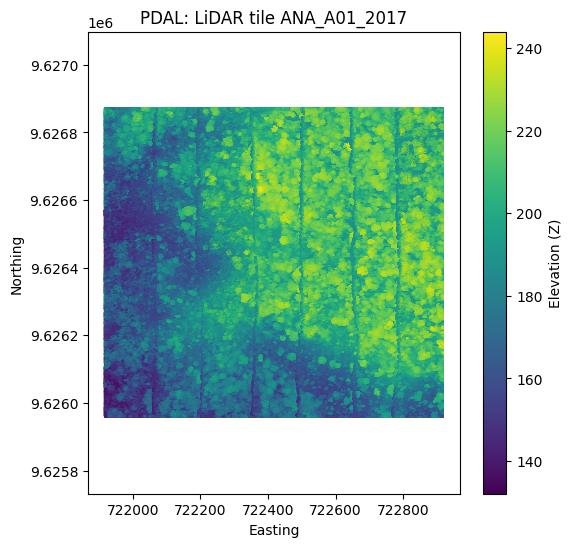

In [86]:
# Define the PDAL pipeline
pipeline_def = {
    "pipeline": [
        path_to_tile_data,
        # Cloth simulation filter for ground classification
        {
            "type": "filters.range",
            "limits": "Z[0:]"  # Optional: filter non-physical points
        },
        {
            "type": "writers.gdal",
            "filename": "surface_dsm.tif",
            "gdaldriver": "GTiff",
            "resolution": 2.0,
            "output_type": "idw"
        }
    ]
}

pipeline = pdal.Pipeline(json.dumps(pipeline_def))
pipeline.execute()
arrays = pipeline.arrays

# Extract the first (and usually only) array
points = arrays[0]
x = points['X']
y = points['Y']
z = points['Z']

# Basic plot
plt.figure(figsize=(6, 6))
plt.scatter(x, y, c=z, s=0.1, cmap="viridis")
plt.title("PDAL: LiDAR tile ANA_A01_2017")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.colorbar(label="Elevation (Z)")
plt.axis("equal")
plt.show()


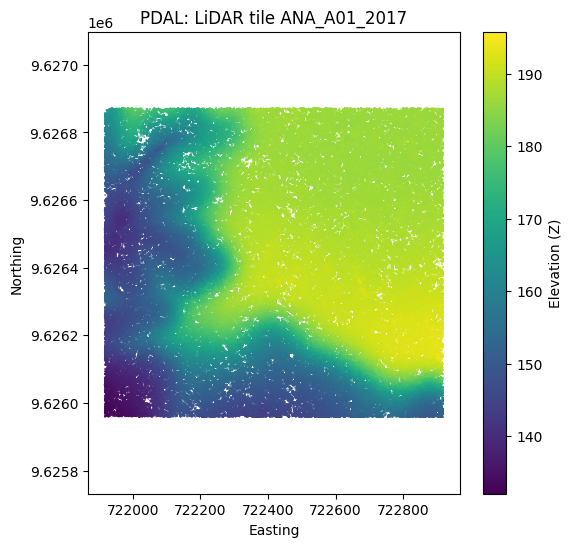

In [87]:
# Define the PDAL pipeline
pipeline_def = {
    "pipeline": [
        path_to_tile_data,
        {
            "type": "filters.smrf"
        },
        {
            "type": "filters.range",
            "limits": "Classification[2:2]"
        },
        {
            "type": "writers.gdal",
            "filename": "ground_only_dtm.tif",
            "gdaldriver": "GTiff",
            "resolution": 2.0,
            "output_type": "idw"
        }
        ]
        }

pipeline = pdal.Pipeline(json.dumps(pipeline_def))
pipeline.execute()
arrays = pipeline.arrays

# Extract the first (and usually only) array
points = arrays[0]
x = points['X']
y = points['Y']
z = points['Z']

# Basic plot
plt.figure(figsize=(6, 6))
plt.scatter(x, y, c=z, s=0.1, cmap="viridis")
plt.title("PDAL: LiDAR tile ANA_A01_2017")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.colorbar(label="Elevation (Z)")
plt.axis("equal")
plt.show()


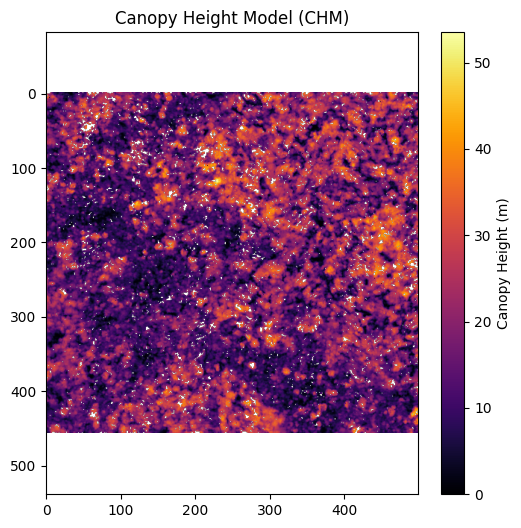

In [88]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

with rasterio.open("surface_dsm.tif") as dsm_src, rasterio.open("ground_only_dtm.tif") as dtm_src:
    dsm = dsm_src.read(1)
    dtm = dtm_src.read(1)
    
    # Mask nodata
    dsm = np.ma.masked_equal(dsm, dsm_src.nodata)
    dtm = np.ma.masked_equal(dtm, dtm_src.nodata)
    
    # Combined mask: exclude any location where either raster has nodata
    mask = np.ma.mask_or(np.ma.getmask(dsm), np.ma.getmask(dtm))
    
    chm = np.ma.array(dsm - dtm, mask=mask)
    
    # Optional: clip unrealistic values
    chm = np.clip(chm, 0, 60)  # e.g. 0–60 m tree height

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(chm, cmap='inferno')
plt.colorbar(label='Canopy Height (m)')
plt.title("Canopy Height Model (CHM)")
plt.axis("equal")
plt.show()


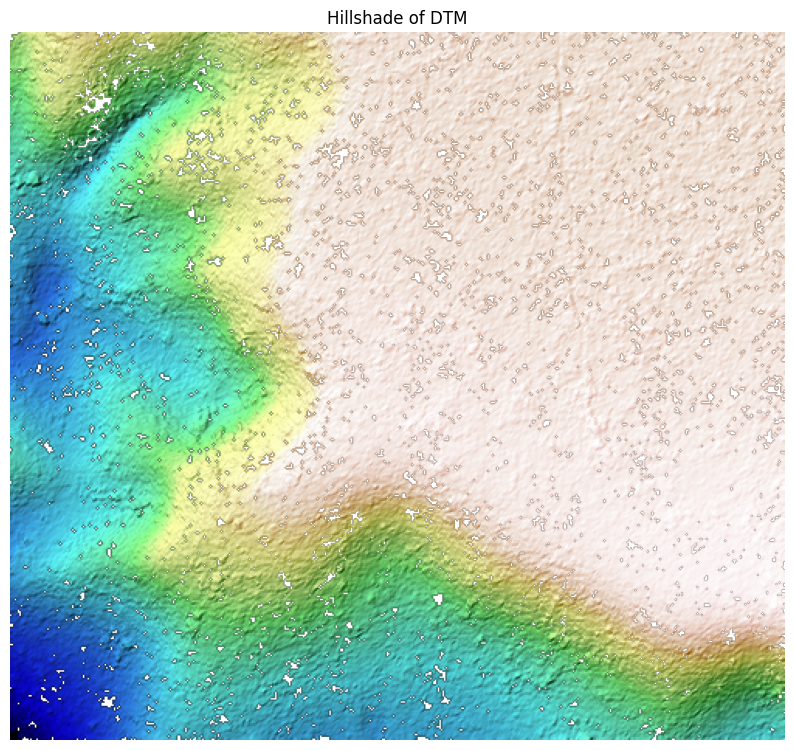

In [102]:
from matplotlib.colors import LightSource

ls = LightSource(azdeg=315, altdeg=45)
hillshade = ls.shade(dtm, cmap=plt.cm.gist_earth, vert_exag=1.5, blend_mode='overlay')

plt.figure(figsize=(10, 10))
plt.imshow(hillshade)
plt.title("Hillshade of DTM")
plt.axis("off")
plt.show()
